# Phase 4: Data Mining

## Imports

In [636]:
from cProfile import label
from itertools import count
from statistics import mean
from turtle import color
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn import metrics, tree
from sklearn.ensemble import GradientBoostingClassifier, RandomForestClassifier
from sklearn.impute import SimpleImputer
from sklearn.model_selection import train_test_split, cross_val_score, cross_validate, GroupKFold, StratifiedGroupKFold, LeavePGroupsOut
import psycopg2
from sklearn.feature_selection import SelectKBest, f_classif, chi2
from sklearn.preprocessing import LabelEncoder, MinMaxScaler
from sklearn.tree import DecisionTreeClassifier
from sqlalchemy import create_engine

## Helper Functions

In [637]:
# Country Codes List
country_codes = ['CAN', 'USA', 'MEX', 'IRN', 'THA', 'UKR', 'CAF', 'TCD', 'MLI']

# Countries organized by development label
countries_by_class_label = {
      'developed': ['CAN', 'USA'],
      'developing': ['MEX', 'IRN', 'THA', 'UKR'],
      'underdeveloped': ['CAF', 'TCD', 'MLI']
}

plt.rcParams['figure.figsize'] = [10, 10]

def get_country_development_class(country_code):
      if country_code in countries_by_class_label['developed']:
            return "developed"
      elif country_code in countries_by_class_label['developing']:
            return "developing"
      elif country_code in countries_by_class_label['underdeveloped']:
            return "underdeveloped"
      else:
            return np.NaN

def get_country_shape(country_code):
      if country_code in countries_by_class_label['developed']:
            return "s"
      elif country_code in countries_by_class_label['developing']:
            return "o"
      else:
            return "^"
      
def get_country_color(country_code):
      if country_code in countries_by_class_label['developed']:
            return "limegreen"
      elif country_code in countries_by_class_label['developing']:
            return "gold"
      else:
            return "red"

## Pulling Data from Dart Mart (PostgreSQL)

In [638]:
# SQL query to pull data from Postgres for data mining
query_pull_data = '''
SELECT DISTINCT 
       C.country_code, D.year_, 
       F.quality_of_life_index, F.human_development_index, F.income_index,
       C.total_population, C.population_growth, C.gdp_constant_2015, C.gdp_growth,
       ED.literacy_rate, ED.government_expenditure_on_education,
       H.birth_rate, H.death_rate, H.capital_health_expenditure, H.prevalence_of_overweight_female, H.prevalence_of_overweight_male, H.prevalence_of_hypertension_female, H.prevalence_of_hypertension_male,
       P.life_expectancy_female, P.life_expectancy_male, P.life_expectancy, P.net_migration, P.labor_force_total, P.unemployment_rate,
       LV.access_electricity, LV.coverage_social_insurance_programs, LV.access_to_fuels_for_cooking
FROM "CSI4142".fact_table as F, "CSI4142".country as C, "CSI4142".date_ as D, "CSI4142".education as ED, "CSI4142".health as H, "CSI4142".living_conditions as LV, "CSI4142".population_ as P
WHERE F.country_surrogate=C.surrogate_key AND
      F.date_surrogate=D.surrogate_key AND
      F.education_surrogate=ED.surrogate_key AND
      F.health_surrogate=H.surrogate_key AND
      F.living_conditions_surrogate=LV.surrogate_key AND
      F.population_surrogate=P.surrogate_key
ORDER BY C.country_code, D.year_
;
'''

# Pull data into dataframe
db_engine = create_engine('postgresql+psycopg2://bazzadev@localhost/bazzadev')
raw_data = pd.read_sql_query(query_pull_data, db_engine)

## Data Summarization

Let's get a feel for the data that we will be working with.

First, we will display the quality of life index for each country using a boxplot:

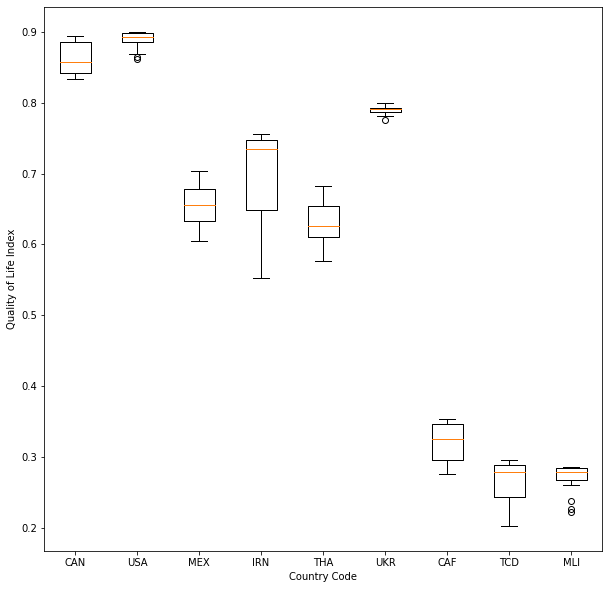

In [639]:
plt.boxplot(
    [raw_data[raw_data['country_code']==code]['human_development_index'] for code in country_codes], 
    labels=country_codes)

plt.xlabel('Country Code')
plt.ylabel('Quality of Life Index')
plt.show()

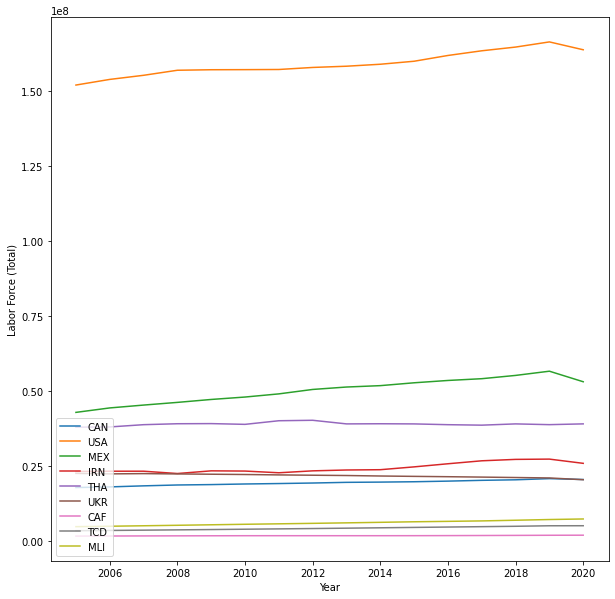

In [640]:
for code in country_codes:
    country_data = raw_data[raw_data['country_code']==code]
    # print(country_data)
    plt.plot(country_data['year_'], country_data['labor_force_total'], label=code)

plt.legend(loc='lower left')

plt.xlabel('Year')
plt.ylabel('Labor Force (Total)')
plt.show()

Next, we will examine the total labor force for each country using a regular plot:

In [641]:


def scatter_1(df):
      countries = {}
      for code in country_codes:
          country_data = df[df['country_code']==code]
          countries[code] = country_data
          plt.scatter(country_data['human_development_index'], country_data['unemployment_rate'], label=code, marker=get_country_shape(code))
      
      plt.legend(loc='upper left')
      
      plt.xlabel('Human Development Index')
      plt.ylabel('Unemployment Rate')
      plt.show()

def hist_1(df):
      df.hist(bins=10)
      plt.show()

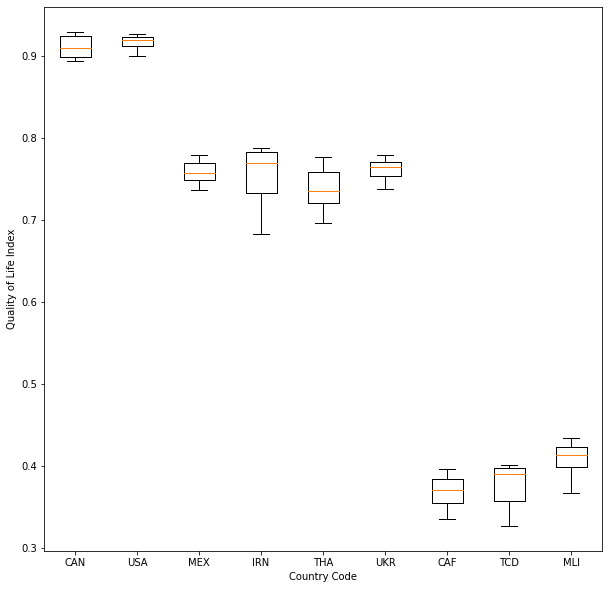

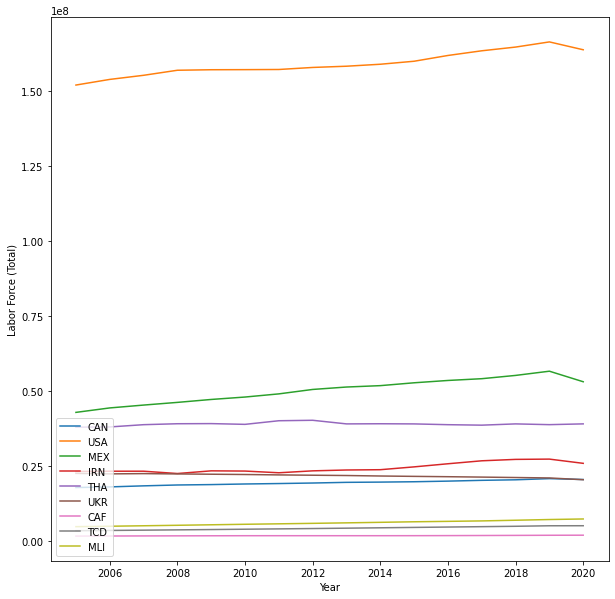

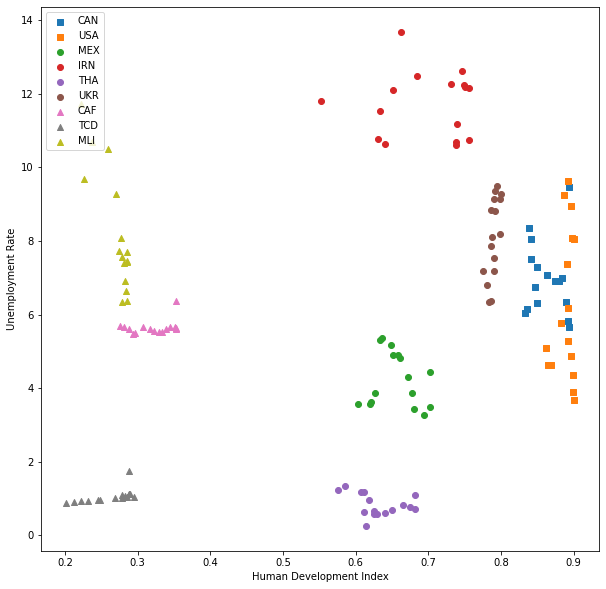

In [642]:
boxplot_1(raw_data)
plot_1(raw_data)
scatter_1(raw_data)
# hist_1(raw_data)

## Data Pre-processing

In [643]:
df = raw_data.copy(deep=True)

df.fillna(method='pad', limit=3)
df = df.fillna(method='bfill', limit=3)

imp = SimpleImputer(missing_values=np.NaN, strategy='mean')

imp_cols = df.columns.to_list()[1:]
df[imp_cols] = pd.DataFrame(imp.fit_transform(df[imp_cols]))

df['development_class'] = df.apply(
      lambda row: get_country_development_class(row.country_code),
      axis=1)

df.insert(1, 'development_class', df.pop('development_class'))

le = LabelEncoder()
df['development_class'] = le.fit_transform(df['development_class'])

group_country = df['country_code']

df.pop('country_code')
# df.pop('human_development_index')
# df.pop('quality_of_life_index')
# df.pop('income_index')

# df = pd.get_dummies(df)

feature_cols = df.columns.to_list()[1:]
label = 'development_class'

df[feature_cols] = pd.DataFrame(
      MinMaxScaler().fit_transform(df[feature_cols]), 
      columns=feature_cols)

X = df[feature_cols]
y = df[label]

print(X)
print(y)

        year_  quality_of_life_index  human_development_index  income_index  \
0    0.000000               0.014950                 0.106017      0.062595   
1    0.066667               0.024917                 0.114613      0.068702   
2    0.133333               0.033223                 0.123209      0.073282   
3    0.200000               0.041528                 0.131805      0.073282   
4    0.266667               0.048173                 0.134670      0.076336   
..        ...                    ...                      ...           ...   
139  0.733333               0.988372                 0.994269      0.984733   
140  0.800000               0.991694                 0.998567      0.989313   
141  0.866667               0.993355                 0.998567      0.995420   
142  0.933333               0.995017                 1.000000      1.000000   
143  1.000000               0.995017                 1.000000      1.000000   

     total_population  population_growth  gdp_const

## Classification

We will be using cross validation to assess the accuracy, precision, and recall 
of the three models we'll be using.

Specifically, we'll be using group $K$-fold cross validation to avoid training and
testing on the same country in any given fold.

First, we write a function which will conduct the cross-validation and performance
assessment for a single model:


In [644]:
def cross_val(X, y, model, cv):
      scores = []
      
      for train, test in cv.split(X, y, groups=group_country):
            X_train, X_test = X.iloc[train], X.iloc[test]
            y_train, y_test = y.iloc[train], y.iloc[test]
            
            b = SelectKBest(chi2, k=X_train.columns.nunique())
            b.fit(X_train, y_train)
            best_features = X_train.columns[b.get_support()]
            
            X_train = X_train[best_features]
            X_test = X_test[best_features]
            
            model.fit(X_train, y_train)
            score = model.score(X_test, y_test)
            scores.append(score)
            
            y_pred = model.predict(X_test)
            
            if score < 1:
                  feats = pd.Series(best_features, name='Feature')
                  feat_scores = pd.Series(b.scores_, name='Score')
                  print( pd.concat([feats, feat_scores], axis=1).sort_values(by=['Score'], ascending=[False]) )
                  
                  country = pd.Series(raw_data.iloc[y_test.index]['country_code'], name='Country Code')
                  actual = pd.Series(y_test, name='Actual')
                  predicted = pd.Series(y_pred, name='Predicted', index=actual.index)
                  
                  # print( pd.concat([country, X_test, actual, predicted], axis=1) )
                  
                  metrics.ConfusionMatrixDisplay.from_predictions(le.inverse_transform(y_test), le.inverse_transform(y_pred), labels=le.classes_)
                  plt.show()
            
      print("Accuracy scores: ", scores)
      print(f"We have a mean accuracy of {np.mean(scores):.2f} and std of {np.std(scores):.2f}\n")

Now we can call this function on each of the three models we're using today -- those being:

- Decision tree
- Gradient boosting
- Random forest


### Sanity Tests - Training & Test Splits

Before we get started, we can run some sanity tests to make sure group $k$-fold
validation is splitting our dataset correctly (eg. we do not test on a country we
have observed in the test set):

In [645]:
def run_sanity_tests():
    cv = GroupKFold(n_splits=group_country.nunique())

    for train, test in cv.split(X, y, groups=group_country):
        X.insert(0, 'country_code', group_country.values)
        print(list(X['country_code'].iloc[train]))
        print(list(X['country_code'].iloc[test]))
        print()
        X.pop('country_code')

# run_sanity_tests()

Now that we've done that, we'll run group $k$-fold cross validation for each of 
our classifiers to determine the better model:

In [646]:
cv = GroupKFold(n_splits=group_country.nunique())

### Decision Tree

                                Feature      Score
25          access_to_fuels_for_cooking  37.914942
10                           birth_rate  32.450786
23                   access_electricity  30.732106
1                 quality_of_life_index  27.628723
2               human_development_index  24.919591
3                          income_index  22.076410
17               life_expectancy_female  19.334430
14        prevalence_of_overweight_male  18.714890
19                      life_expectancy  18.177790
18                 life_expectancy_male  17.093498
13      prevalence_of_overweight_female  15.363147
11                           death_rate  11.974600
5                     population_growth  10.733637
8                         literacy_rate  10.442246
4                      total_population   8.626220
15    prevalence_of_hypertension_female   8.354419
21                    labor_force_total   7.718993
9   government_expenditure_on_education   7.125558
12           capital_health_exp

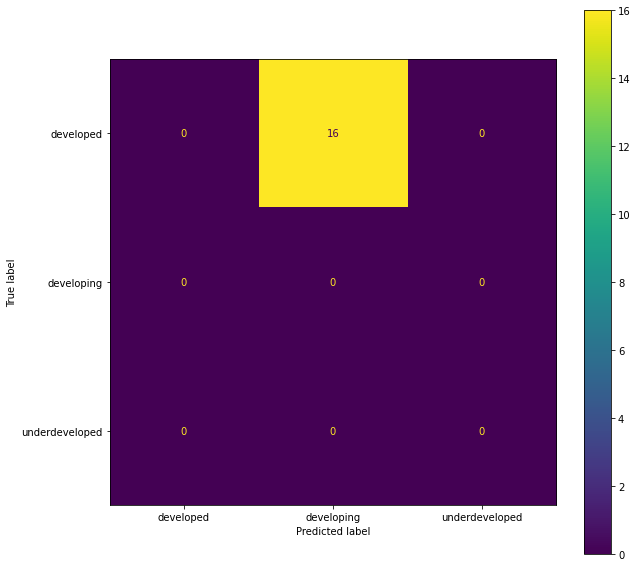

                                Feature      Score
6                     gdp_constant_2015  38.535876
10                           birth_rate  38.309557
25          access_to_fuels_for_cooking  26.888926
2               human_development_index  21.396902
1                 quality_of_life_index  20.639987
23                   access_electricity  20.376532
21                    labor_force_total  18.564853
14        prevalence_of_overweight_male  18.424443
3                          income_index  16.319501
5                     population_growth  16.023984
4                      total_population  15.759584
20                        net_migration  15.442761
13      prevalence_of_overweight_female  14.093106
17               life_expectancy_female  12.982769
19                      life_expectancy  12.084520
12           capital_health_expenditure  11.512421
18                 life_expectancy_male  11.272199
8                         literacy_rate   8.858688
11                           de

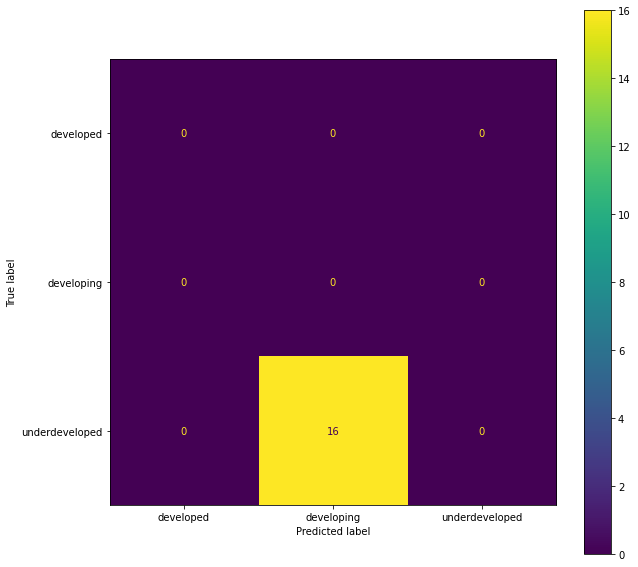

Accuracy scores:  [0.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.0]
We have a mean accuracy of 0.78 and std of 0.42



In [647]:
clf = DecisionTreeClassifier()
cross_val(X, y, clf, cv)

### Gradient Boosting

                                Feature      Score
25          access_to_fuels_for_cooking  37.914942
10                           birth_rate  32.450786
23                   access_electricity  30.732106
1                 quality_of_life_index  27.628723
2               human_development_index  24.919591
3                          income_index  22.076410
17               life_expectancy_female  19.334430
14        prevalence_of_overweight_male  18.714890
19                      life_expectancy  18.177790
18                 life_expectancy_male  17.093498
13      prevalence_of_overweight_female  15.363147
11                           death_rate  11.974600
5                     population_growth  10.733637
8                         literacy_rate  10.442246
4                      total_population   8.626220
15    prevalence_of_hypertension_female   8.354419
21                    labor_force_total   7.718993
9   government_expenditure_on_education   7.125558
12           capital_health_exp

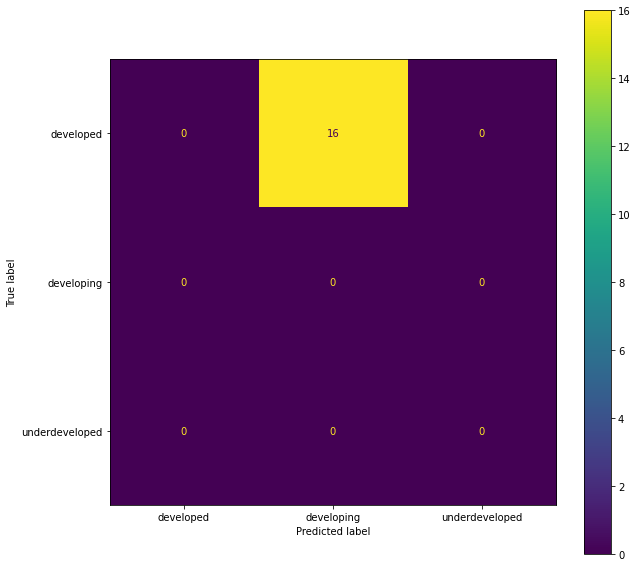

                                Feature      Score
6                     gdp_constant_2015  38.948071
25          access_to_fuels_for_cooking  38.521288
1                 quality_of_life_index  30.893628
10                           birth_rate  30.605490
23                   access_electricity  30.569649
2               human_development_index  28.151193
3                          income_index  26.295379
21                    labor_force_total  23.273438
11                           death_rate  21.735664
14        prevalence_of_overweight_male  21.526791
4                      total_population  20.684793
17               life_expectancy_female  20.190969
19                      life_expectancy  19.450659
18                 life_expectancy_male  18.706216
20                        net_migration  17.679311
13      prevalence_of_overweight_female  16.158540
12           capital_health_expenditure  12.510486
8                         literacy_rate  10.795392
15    prevalence_of_hypertensio

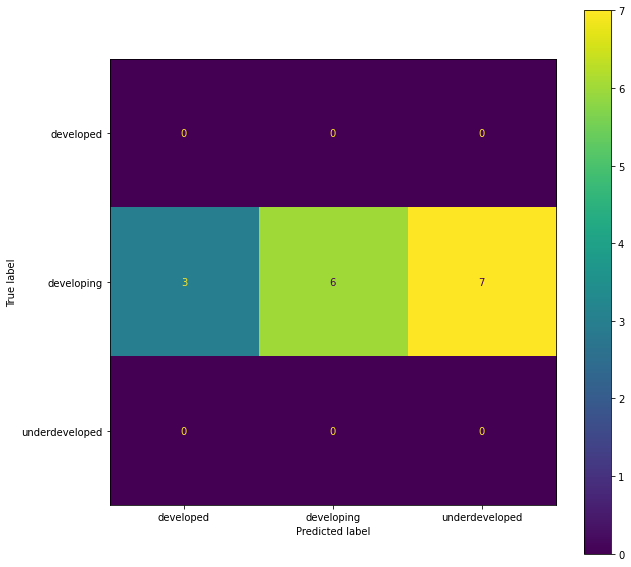

                                Feature      Score
6                     gdp_constant_2015  85.342202
21                    labor_force_total  48.188779
4                      total_population  43.572824
25          access_to_fuels_for_cooking  37.605414
23                   access_electricity  30.566272
10                           birth_rate  30.559051
1                 quality_of_life_index  27.830989
20                        net_migration  25.784784
2               human_development_index  25.719286
3                          income_index  23.378786
14        prevalence_of_overweight_male  19.049657
17               life_expectancy_female  18.377000
19                      life_expectancy  16.963919
13      prevalence_of_overweight_female  15.646924
18                 life_expectancy_male  15.586933
12           capital_health_expenditure  12.405026
5                     population_growth  11.527861
8                         literacy_rate  10.478622
11                           de

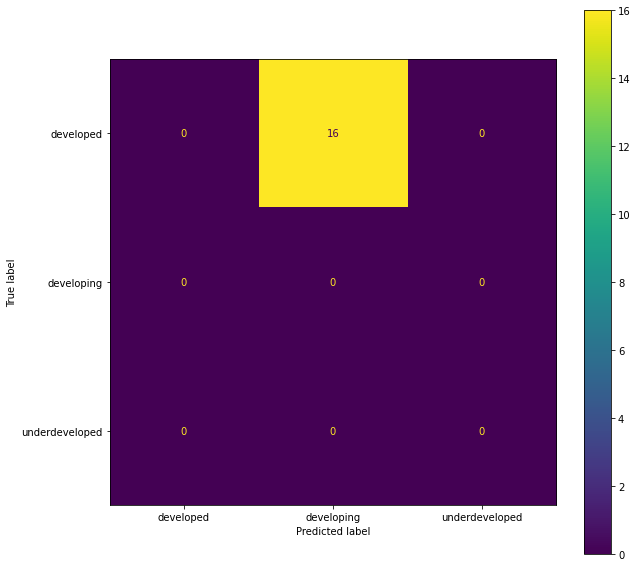

Accuracy scores:  [0.0, 0.375, 1.0, 1.0, 1.0, 1.0, 1.0, 0.0, 1.0]
We have a mean accuracy of 0.71 and std of 0.42



In [648]:
clf = GradientBoostingClassifier()
cross_val(X, y, clf, cv)

### Random Forest

                                Feature      Score
25          access_to_fuels_for_cooking  37.914942
10                           birth_rate  32.450786
23                   access_electricity  30.732106
1                 quality_of_life_index  27.628723
2               human_development_index  24.919591
3                          income_index  22.076410
17               life_expectancy_female  19.334430
14        prevalence_of_overweight_male  18.714890
19                      life_expectancy  18.177790
18                 life_expectancy_male  17.093498
13      prevalence_of_overweight_female  15.363147
11                           death_rate  11.974600
5                     population_growth  10.733637
8                         literacy_rate  10.442246
4                      total_population   8.626220
15    prevalence_of_hypertension_female   8.354419
21                    labor_force_total   7.718993
9   government_expenditure_on_education   7.125558
12           capital_health_exp

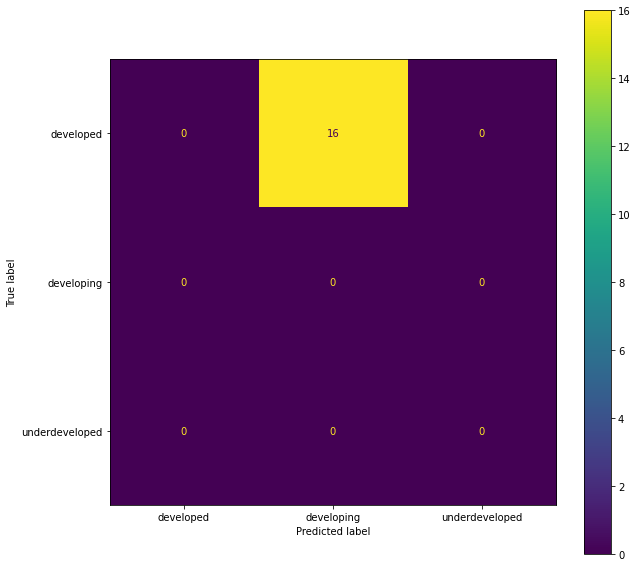

                                Feature      Score
6                     gdp_constant_2015  38.948071
25          access_to_fuels_for_cooking  38.521288
1                 quality_of_life_index  30.893628
10                           birth_rate  30.605490
23                   access_electricity  30.569649
2               human_development_index  28.151193
3                          income_index  26.295379
21                    labor_force_total  23.273438
11                           death_rate  21.735664
14        prevalence_of_overweight_male  21.526791
4                      total_population  20.684793
17               life_expectancy_female  20.190969
19                      life_expectancy  19.450659
18                 life_expectancy_male  18.706216
20                        net_migration  17.679311
13      prevalence_of_overweight_female  16.158540
12           capital_health_expenditure  12.510486
8                         literacy_rate  10.795392
15    prevalence_of_hypertensio

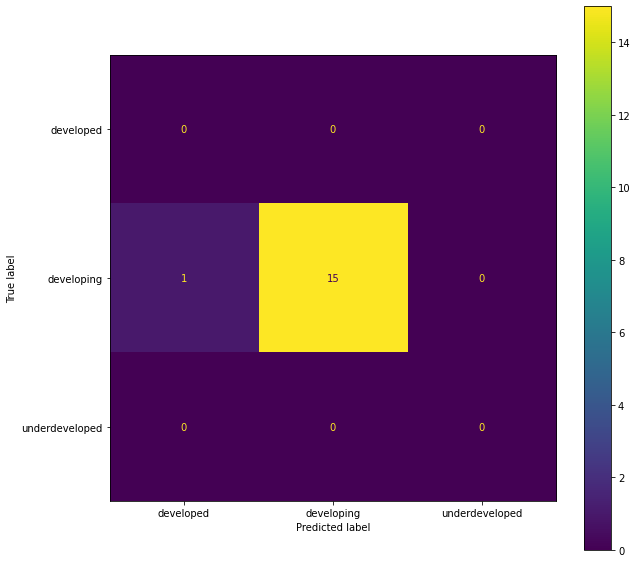

                                Feature      Score
6                     gdp_constant_2015  85.342202
21                    labor_force_total  48.188779
4                      total_population  43.572824
25          access_to_fuels_for_cooking  37.605414
23                   access_electricity  30.566272
10                           birth_rate  30.559051
1                 quality_of_life_index  27.830989
20                        net_migration  25.784784
2               human_development_index  25.719286
3                          income_index  23.378786
14        prevalence_of_overweight_male  19.049657
17               life_expectancy_female  18.377000
19                      life_expectancy  16.963919
13      prevalence_of_overweight_female  15.646924
18                 life_expectancy_male  15.586933
12           capital_health_expenditure  12.405026
5                     population_growth  11.527861
8                         literacy_rate  10.478622
11                           de

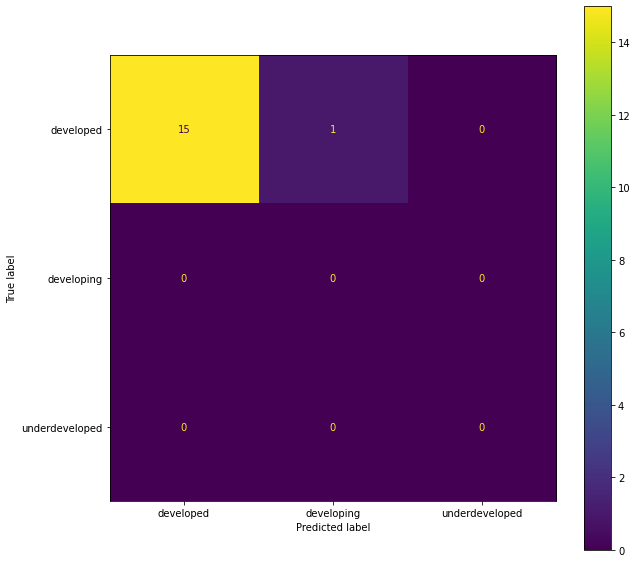

Accuracy scores:  [0.0, 0.9375, 1.0, 1.0, 1.0, 1.0, 1.0, 0.9375, 1.0]
We have a mean accuracy of 0.88 and std of 0.31



In [649]:
clf = RandomForestClassifier()
cross_val(X, y, clf, cv)